# Colour Correction using Splines

### Define constants

In [61]:
%load_ext autoreload
%autoreload 2
import colour
from data import load_dataset_sfu, load_dataset_csv, load_illuminant_cmfs, load_camera
import numpy as np

RANDOM_STATE = 0
np.random.seed(RANDOM_STATE)

SFU_FILE_PATH = 'reflect_db.reflect'
CAVE_FOSTER2004_PATH = 'cave_foster2004.csv'
FOSTER_50_PATH = 'foster50.csv'
CAMERA = 'nikon'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
sfu_dataset = load_dataset_sfu(SFU_FILE_PATH)
cave_foster2004_dataset = load_dataset_csv(CAVE_FOSTER2004_PATH)
foster_50_dataset = load_dataset_csv(FOSTER_50_PATH)

TRAIN = cave_foster2004_dataset
TEST = foster_50_dataset
VALIDATION = sfu_dataset


### Spectral sensitivities of various cameras

In [63]:

MSDS_TRAIN, SDS_TRAIN = load_camera(CAMERA)

[ 0.98103242  1.          1.        ]
1


### Computing Observer Responses
We can easily change the order of test and train sets here

c:\Users\jonis\anaconda3\envs\colour\lib\site-packages\colour\utilities\verbose.py:265: ColourRuntimeWarning: Non-sibling elements are passed-through: "[RGB_CameraSensitivities([[  4.00000000e+02,  -1.62630326e-19,   1.08420217e-19,
                            1.53246069e-03],
                         [  4.10000000e+02,   2.92397467e-03,   1.33571498e-03,
                            1.66082877e-02],
                         [  4.20000000e+02,   4.95978648e-02,   6.49710245e-02,
                            3.61713504e-01],
                         [  4.30000000e+02,   7.65889271e-02,   1.37065825e-01,
                            7.55343600e-01],
                         [  4.40000000e+02,   6.13181619e-02,   1.68640055e-01,
                            8.74945234e-01],
                         [  4.50000000e+02,   4.88620474e-02,   1.96032635e-01,
                            9.63140880e-01],
                         [  4.60000000e+02,   4.02284533e-02,   2.54243574e-01,
                 

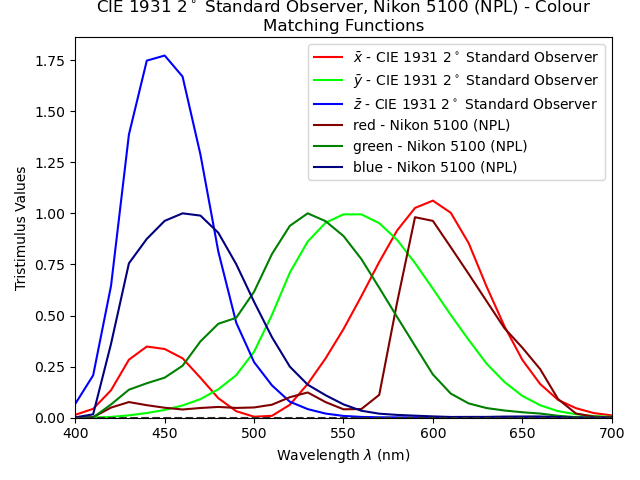

In [64]:
illuminant, cmfs = load_illuminant_cmfs()
colour.plotting.plot_multi_cmfs([MSDS_TRAIN, cmfs])
response_trainset_xyz = colour.characterisation.training_data_sds_to_XYZ(TRAIN, cmfs, illuminant, None)
response_testset_xyz = colour.characterisation.training_data_sds_to_XYZ(TEST, cmfs, illuminant, None)
response_validation_xyz = colour.characterisation.training_data_sds_to_XYZ(VALIDATION, cmfs, illuminant, None)

### Chromaticity Diagrams

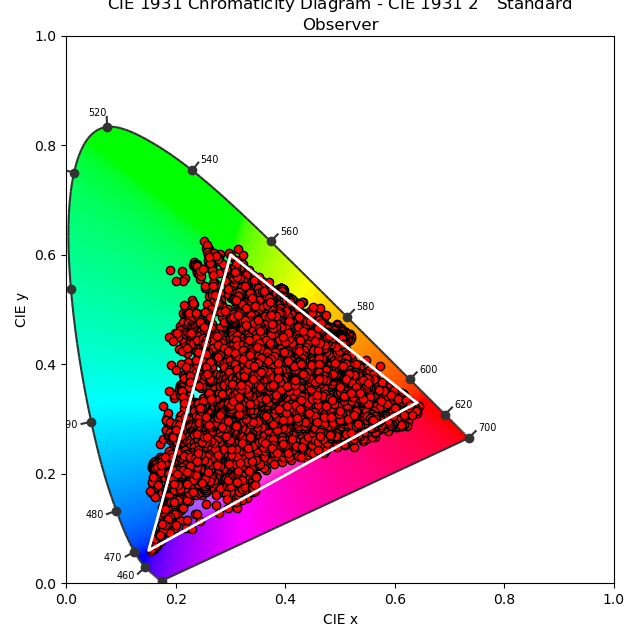

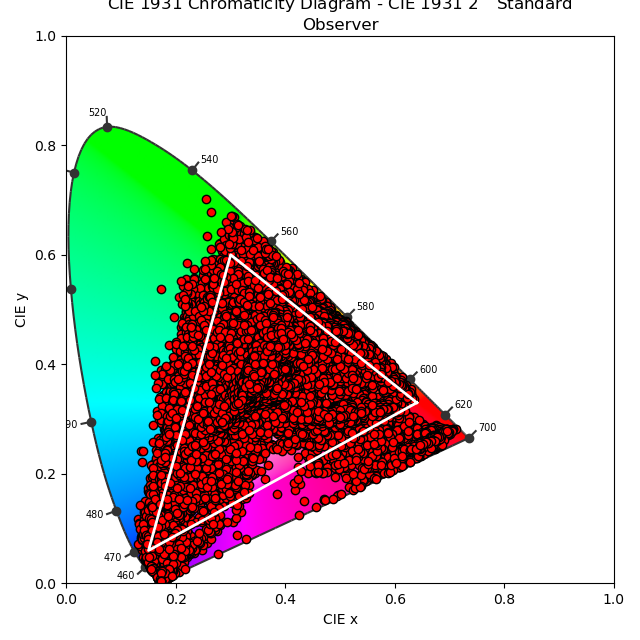

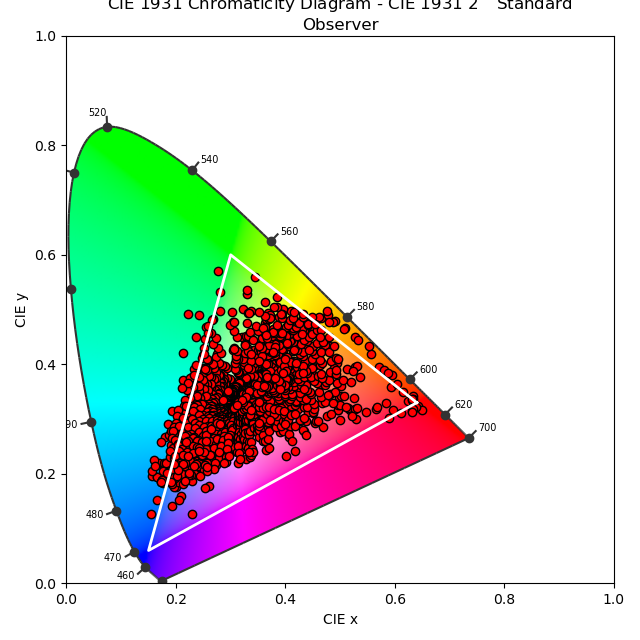

In [65]:
from plotting import plot_chromaticity_diagram
plot_chromaticity_diagram(response_trainset_xyz)
plot_chromaticity_diagram(response_testset_xyz)
plot_chromaticity_diagram(response_validation_xyz)

### Computing Camera Responses

In [66]:
response_trainset_camera, wb1 = colour.characterisation.training_data_sds_to_RGB(TRAIN, MSDS_TRAIN, SDS_TRAIN)
response_testset_camera, wb2 = colour.characterisation.training_data_sds_to_RGB(TEST, MSDS_TRAIN, SDS_TRAIN)
response_validationset_camera,  wb3 = colour.characterisation.training_data_sds_to_RGB(VALIDATION, MSDS_TRAIN, SDS_TRAIN)

0.958363510352
0.958763661744
0.870621325625


### Fit Generalized Additive Model with P-splines

### Nikon

In [77]:
from sklearn.metrics import make_scorer
from colour_math import deltae_mean
from models import GAMOptimizer
from evaluate import pred
np.int = np.int64
# gam = GAMOptimizer(lams=1e-6, order=3, n_splines=5)
# gam = GAMOptimizer(lams=0.0001,order=3, n_splines=10)
gam = GAMOptimizer(lams=0.01,order=3, n_splines=20)

gam.fit(response_trainset_camera, response_trainset_xyz)

pred(gam, response_testset_camera, response_testset_xyz, "DeltaE Foster+CAVE")

3600
---- RESULTS DeltaE Foster+CAVE ----
DeltaE mean: 0.83
DeltaE max: 5.77
DeltaE median: 0.71
DeltaE 95 percentile: 1.92
DeltaE 99 percentile: 2.42


### Sigma

In [68]:
from sklearn.metrics import make_scorer
from colour_math import deltae_mean
from models import GAMOptimizer
from evaluate import pred
np.int = np.int64
gam = GAMOptimizer(lams=1e-9, order=3, n_splines=5)
# gam = GAMOptimizer(lams=0.0001,order=3, n_splines=10)
# gam = GAMOptimizer(lams=0.0001,order=3, n_splines=20)

gam.fit(response_trainset_camera, response_trainset_xyz)

pred(gam, response_testset_camera, response_testset_xyz, "DeltaE Foster+CAVE")

225
---- RESULTS DeltaE Foster+CAVE ----
DeltaE mean: 0.94
DeltaE max: 4.81
DeltaE median: 0.81
DeltaE 95 percentile: 2.08
DeltaE 99 percentile: 2.48


(100, 100)
2.63124682971
-0.0759580249079


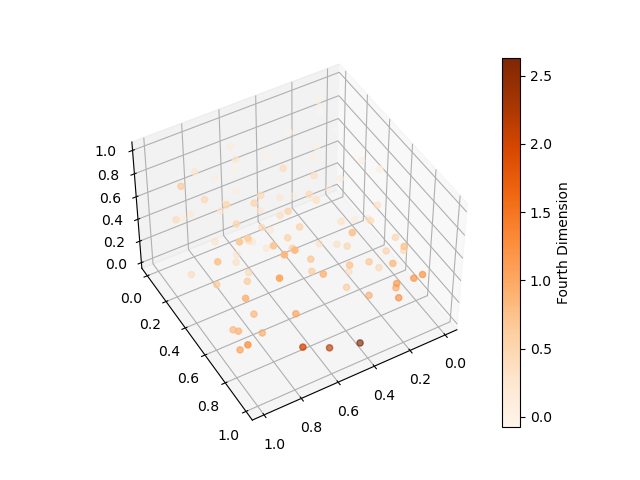

In [69]:
gam.plot_4d()

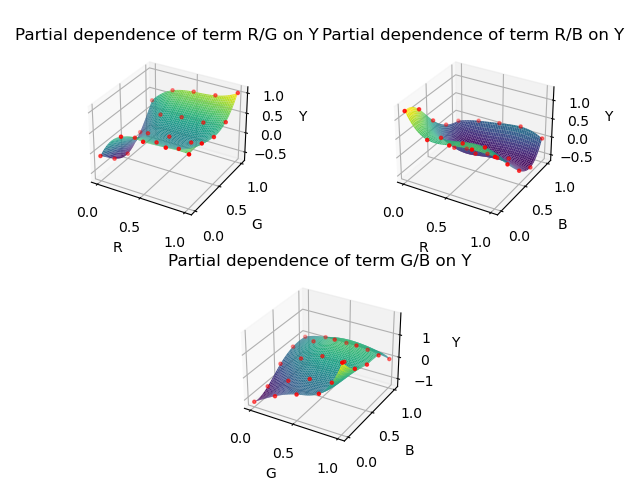

In [70]:
%matplotlib ipympl

gam.plot_partial_dependences_for_Y()

### Fit Linear Model

In [72]:
from sklearn.linear_model import LinearRegression

linear = LinearRegression(fit_intercept=False)


linear.fit(response_trainset_camera, response_trainset_xyz)
pred(linear, response_testset_camera, response_testset_xyz, "Foster 50")


---- RESULTS Foster 50 ----
DeltaE mean: 1.00
DeltaE max: 5.56
DeltaE median: 0.86
DeltaE 95 percentile: 2.18
DeltaE 99 percentile: 2.93


### Fit 3rd order Root-Polynomial Model

In [73]:
from models import PolynomialTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

RP_linear_3 = Pipeline([
    ('transformer', PolynomialTransformer(degree=3, rp=True)),
    ('regressor', LinearRegression(fit_intercept=False))
])

RP_linear_3.fit(response_trainset_camera, response_trainset_xyz)

pred(RP_linear_3, response_testset_camera, response_testset_xyz, "DeltaE Foster+CAVE")


---- RESULTS DeltaE Foster+CAVE ----
DeltaE mean: 1.06
DeltaE max: 5.69
DeltaE median: 0.85
DeltaE 95 percentile: 2.43
DeltaE 99 percentile: 3.00


### Fit a 2nd order Root-Polynomial Model

In [74]:
from models import GAMOptimizer, PolynomialTransformer, DeltaEOptimizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

RP_linear_2 = Pipeline([
    ('transformer', PolynomialTransformer(degree=2, rp=True)),
    ('regressor', LinearRegression(fit_intercept=False))
])


RP_linear_2.fit(response_trainset_camera, response_trainset_xyz)
pred(RP_linear_2, response_testset_camera, response_testset_xyz, "DeltaE Foster+CAVE")


---- RESULTS DeltaE Foster+CAVE ----
DeltaE mean: 1.05
DeltaE max: 5.54
DeltaE median: 0.84
DeltaE 95 percentile: 2.44
DeltaE 99 percentile: 3.06


In [75]:
P_Linear_3 = Pipeline([
    ('transformer', PolynomialTransformer(degree=3, rp=False)),
    ('regressor', LinearRegression(fit_intercept=False))
])


P_Linear_3.fit(response_trainset_camera, response_trainset_xyz)
pred(P_Linear_3, response_testset_camera, response_testset_xyz, "DeltaE Foster+CAVE")
pred(P_Linear_3, response_testset_camera, response_testset_xyz, "DeltaE SFU")

---- RESULTS DeltaE Foster+CAVE ----
DeltaE mean: 1.07
DeltaE max: 5.40
DeltaE median: 0.90
DeltaE 95 percentile: 2.37
DeltaE 99 percentile: 2.98
---- RESULTS DeltaE SFU ----
DeltaE mean: 1.07
DeltaE max: 5.40
DeltaE median: 0.90
DeltaE 95 percentile: 2.37
DeltaE 99 percentile: 2.98


In [ ]:
P_linear = Pipeline([
    ('transformer', PolynomialTransformer(degree=2, rp=False)),
    ('regressor', LinearRegression(fit_intercept=False))
])


P_linear.fit(response_trainset_camera, response_trainset_xyz)
pred(P_linear, response_testset_camera, response_testset_xyz, "DeltaE Foster+CAVE")


---- RESULTS DeltaE Foster+CAVE ----
DeltaE mean: 1.11
DeltaE max: 5.25
DeltaE median: 0.96
DeltaE 95 percentile: 2.38
DeltaE 99 percentile: 2.97


In [ ]:
from sklearn.pipeline import Pipeline
from models import DeltaEOptimizer

DE2000P = Pipeline([
    ('regressor', DeltaEOptimizer(root_polynomial=False, degree=3))
])


DE2000P.fit(response_trainset_camera, response_trainset_xyz)
pred(DE2000P, response_testset_camera, response_testset_xyz, "DeltaE Foster+CAVE")
pred(DE2000P, response_validationset_camera, response_validation_xyz, "DeltaE SFU")

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.619073115732
        x: [ 6.570e-01  2.916e-01 ...,  4.834e-01 -1.965e+00]
      nit: 289
      jac: [ 3.800e-07  8.494e-07 ..., -1.505e-06  9.201e-06]
 hess_inv: [[ 1.113e-01 -1.505e-01 ...,  8.380e-01 -7.498e-01]
            [-1.505e-01  4.489e-01 ..., -2.776e+00  3.656e+00]
            ..., 
            [ 8.380e-01 -2.776e+00 ...,  5.550e+02 -6.234e+02]
            [-7.498e-01  3.656e+00 ..., -6.234e+02  1.539e+03]]
     nfev: 17458
     njev: 301
---- RESULTS DeltaE Foster+CAVE ----
DeltaE mean: 0.89
DeltaE max: 7.24
DeltaE median: 0.74
DeltaE 95 percentile: 2.00
DeltaE 99 percentile: 2.44
---- RESULTS DeltaE SFU ----
DeltaE mean: 1.08
DeltaE max: 5.31
DeltaE median: 0.83
DeltaE 95 percentile: 2.72
DeltaE 99 percentile: 4.05


In [ ]:
from sklearn.pipeline import Pipeline
from models import DeltaEOptimizer

DE2000RP = Pipeline([
    ('regressor', DeltaEOptimizer(root_polynomial=True, degree=3))
])


DE2000RP.fit(response_trainset_camera, response_trainset_xyz)
pred(DE2000RP, response_testset_camera, response_testset_xyz, "DeltaE Foster+CAVE")
pred(DE2000RP, response_validationset_camera, response_validation_xyz, "DeltaE SFU")

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.643307047468
        x: [ 3.196e-03 -9.187e+00 ...,  1.004e+01 -5.145e+00]
      nit: 437
      jac: [-9.924e-06 -6.460e-06 ...,  2.190e-06  1.244e-06]
 hess_inv: [[ 3.758e+01  1.373e+02 ..., -6.312e+01  3.763e+00]
            [ 1.373e+02  1.289e+03 ...,  1.198e+01  5.719e+02]
            ..., 
            [-6.312e+01  1.198e+01 ...,  1.441e+03  2.432e+02]
            [ 3.763e+00  5.719e+02 ...,  2.432e+02  3.572e+03]]
     nfev: 19600
     njev: 490
---- RESULTS DeltaE Foster+CAVE ----
DeltaE mean: 0.90
DeltaE max: 8.09
DeltaE median: 0.73
DeltaE 95 percentile: 2.17
DeltaE 99 percentile: 2.95
---- RESULTS DeltaE SFU ----
DeltaE mean: 1.07
DeltaE max: 5.12
DeltaE median: 0.88
DeltaE 95 percentile: 2.37
DeltaE 99 percentile: 3.63


In [ ]:
from sklearn.pipeline import Pipeline
from models import DeltaEOptimizer

DE2000RP = Pipeline([
    ('regressor', DeltaEOptimizer(root_polynomial=False, degree=1))
])


DE2000RP.fit(response_trainset_camera, response_trainset_xyz)
pred(DE2000RP, response_testset_camera, response_testset_xyz, "DeltaE Foster+CAVE")
pred(DE2000RP, response_validationset_camera, response_validation_xyz, "DeltaE SFU")

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.878959718308
        x: [ 6.631e-01  2.645e-01  2.677e-02  2.493e-01  1.040e+00
            -2.905e-01  3.964e-02 -2.684e-01  1.252e+00]
      nit: 26
      jac: [ 1.088e-06  2.630e-06  4.254e-06 -2.116e-06 -3.755e-06
            -5.700e-06  1.691e-06  1.639e-06  1.244e-06]
 hess_inv: [[ 2.955e-02 -5.090e-02 ..., -3.260e-02  1.615e-02]
            [-5.090e-02  1.409e-01 ...,  9.903e-02 -6.615e-02]
            ..., 
            [-3.260e-02  9.903e-02 ...,  1.418e-01 -1.048e-01]
            [ 1.615e-02 -6.615e-02 ..., -1.048e-01  1.025e-01]]
     nfev: 410
     njev: 41
---- RESULTS DeltaE Foster+CAVE ----
DeltaE mean: 0.92
DeltaE max: 5.18
DeltaE median: 0.78
DeltaE 95 percentile: 2.00
DeltaE 99 percentile: 2.59
---- RESULTS DeltaE SFU ----
DeltaE mean: 1.24
DeltaE max: 6.01
DeltaE median: 0.92
DeltaE 95 percentile: 3.36
DeltaE 99 percentile: 4.70


In [ ]:

DE2000RP = Pipeline([
    ('regressor', DeltaEOptimizer(root_polynomial=False, degree=1))
])


DE2000RP.fit(response_trainset_camera, response_trainset_xyz)
pred(DE2000RP, response_testset_camera, response_testset_xyz, "DeltaE Foster+CAVE")
#pred(DE2000RP, response_validationset_camera, response_validation_xyz, "DeltaE SFU")

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.878959718308
        x: [ 6.631e-01  2.645e-01  2.677e-02  2.493e-01  1.040e+00
            -2.905e-01  3.964e-02 -2.684e-01  1.252e+00]
      nit: 26
      jac: [ 1.088e-06  2.630e-06  4.254e-06 -2.116e-06 -3.755e-06
            -5.700e-06  1.691e-06  1.639e-06  1.244e-06]
 hess_inv: [[ 2.955e-02 -5.090e-02 ..., -3.260e-02  1.615e-02]
            [-5.090e-02  1.409e-01 ...,  9.903e-02 -6.615e-02]
            ..., 
            [-3.260e-02  9.903e-02 ...,  1.418e-01 -1.048e-01]
            [ 1.615e-02 -6.615e-02 ..., -1.048e-01  1.025e-01]]
     nfev: 410
     njev: 41
---- RESULTS DeltaE Foster+CAVE ----
DeltaE mean: 0.92
DeltaE max: 5.18
DeltaE median: 0.78
DeltaE 95 percentile: 2.00
DeltaE 99 percentile: 2.59


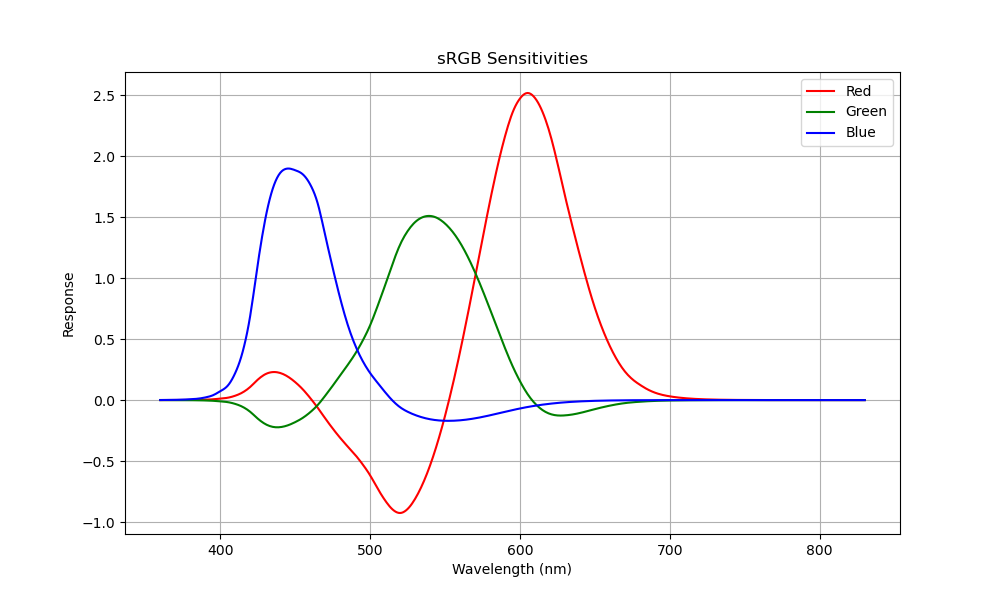

In [ ]:
import colour
import matplotlib.pyplot as plt
import numpy as np

# Retrieve the XYZ colour matching functions.
cmfs = colour.colorimetry.MSDS_CMFS['CIE 1931 2 Degree Standard Observer']

# Wavelengths of the standard observer.
wavelengths = cmfs.wavelengths

# Converting XYZ to sRGB sensitivities
# sRGB colour matching functions are derived from the XYZ ones by applying the sRGB colour space matrix.
rgb_colourspace = colour.RGB_COLOURSPACES['sRGB']
matrix_XYZ_to_RGB = rgb_colourspace.matrix_XYZ_to_RGB

# Applying the matrix to each XYZ sensitivity
sRGB_sensitivities = np.dot(cmfs.values, matrix_XYZ_to_RGB.T)

# Plotting the sensitivities
plt.figure(figsize=(10, 6))
plt.plot(wavelengths, sRGB_sensitivities[:, 0], label='Red', color='r')
plt.plot(wavelengths, sRGB_sensitivities[:, 1], label='Green', color='g')
plt.plot(wavelengths, sRGB_sensitivities[:, 2], label='Blue', color='b')
plt.title('sRGB Sensitivities')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Response')
plt.legend()
plt.grid(True)


In [ ]:
from models import GAMOptimizer
from evaluate import pred
from sklearn.pipeline import Pipeline
from models import PolynomialTransformer
from sklearn.linear_model import LinearRegression
from colour import SpectralShape
from colour import MSDS_CAMERA_SENSITIVITIES, MSDS_CMFS
import numpy as np
#spectra = Pipeline([
#    ('transformer', PolynomialTransformer(degree=3, rp=False)),
#    ('regressor', LinearRegression(fit_intercept=False))
# ])

spectra = GAMOptimizer(lams=1e-3, order=3, n_splines=20)


cmfs = MSDS_CMFS['CIE 1931 2 Degree Standard Observer'].copy()
MSDS_TRAIN = MSDS_CAMERA_SENSITIVITIES['Nikon 5100 (NPL)']
cmfs.values = cmfs.values / np.max(cmfs.values)
source = MSDS_TRAIN.align(SpectralShape(400, 700, 1)).values
target = cmfs.align(SpectralShape(400, 700, 1)).values
print(MSDS_TRAIN.wavelengths)
spectra.fit(source, target)

[ 400.  401.  402.  403.  404.  405.  406.  407.  408.  409.  410.  411.
  412.  413.  414.  415.  416.  417.  418.  419.  420.  421.  422.  423.
  424.  425.  426.  427.  428.  429.  430.  431.  432.  433.  434.  435.
  436.  437.  438.  439.  440.  441.  442.  443.  444.  445.  446.  447.
  448.  449.  450.  451.  452.  453.  454.  455.  456.  457.  458.  459.
  460.  461.  462.  463.  464.  465.  466.  467.  468.  469.  470.  471.
  472.  473.  474.  475.  476.  477.  478.  479.  480.  481.  482.  483.
  484.  485.  486.  487.  488.  489.  490.  491.  492.  493.  494.  495.
  496.  497.  498.  499.  500.  501.  502.  503.  504.  505.  506.  507.
  508.  509.  510.  511.  512.  513.  514.  515.  516.  517.  518.  519.
  520.  521.  522.  523.  524.  525.  526.  527.  528.  529.  530.  531.
  532.  533.  534.  535.  536.  537.  538.  539.  540.  541.  542.  543.
  544.  545.  546.  547.  548.  549.  550.  551.  552.  553.  554.  555.
  556.  557.  558.  559.  560.  561.  562.  563.  5

GAMOptimizer(lams=0.001, n_splines=20, order=3)

c:\Users\jonis\anaconda3\envs\colour\lib\site-packages\colour\utilities\verbose.py:265: ColourRuntimeWarning: Aligning "E" illuminant shape to "CIE 1931 2 Degree Standard Observer" colour matching functions shape.
  warn(*args, **kwargs)  # noqa: B028
c:\Users\jonis\anaconda3\envs\colour\lib\site-packages\colour\utilities\verbose.py:265: ColourRuntimeWarning: Aligning "x_bar" spectral data shape to "(360.0, 780.0, 1.0)".
  warn(*args, **kwargs)  # noqa: B028
c:\Users\jonis\anaconda3\envs\colour\lib\site-packages\colour\utilities\verbose.py:265: ColourRuntimeWarning: Aligning "E" illuminant shape to "(360.0, 780.0, 1.0)".
  warn(*args, **kwargs)  # noqa: B028
c:\Users\jonis\anaconda3\envs\colour\lib\site-packages\colour\utilities\verbose.py:265: ColourRuntimeWarning: Aligning "E" illuminant shape to "CIE 1931 2 Degree Standard Observer" colour matching functions shape.
  warn(*args, **kwargs)  # noqa: B028
c:\Users\jonis\anaconda3\envs\colour\lib\site-packages\colour\utilities\verbose.p

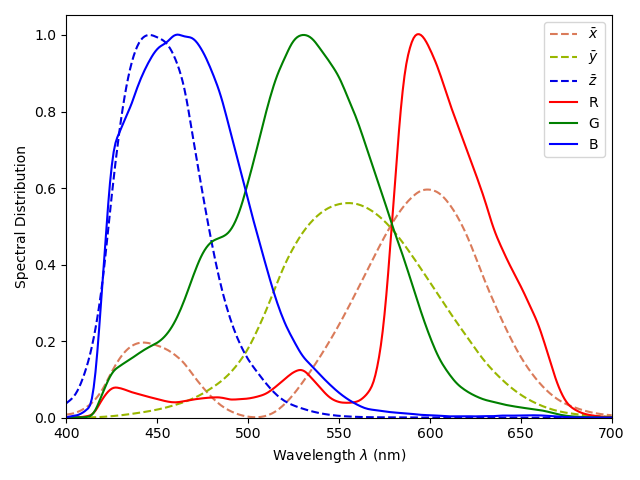

In [ ]:
from colour.plotting import plot_multi_sds
from colour import MultiSpectralDistributions
import matplotlib.pyplot as plt
out = spectra.predict(MSDS_TRAIN.values)
out[out<0] = 0
out_spectra = MultiSpectralDistributions(out, SpectralShape(400, 700, 1))
plot_kwargs = [
    {"use_sd_colours": True, "linestyle": "dashed"},
    {"use_sd_colours": True, "linestyle": "dashed"},
    {"use_sd_colours": True, "linestyle": "dashed"},

    {"use_sd_colours": False, "linestyle": "solid", "color": "red", "label": "R"},
    {"use_sd_colours": False, "linestyle": "solid", "color": "green", "label": "G"},
    {"use_sd_colours": False, "linestyle": "solid", "color": "blue", "label": "B"},
]
fig, ax = plot_multi_sds([cmfs, MSDS_TRAIN], plot_kwargs=plot_kwargs, transparent_background=False)
plt.subplots_adjust(top=0.85)

plt.title("Nikon D5100 vs CIE XYZ 1931 Spectral Sensitivities", weight="bold")
plt.savefig("spectralsensitivities.png", transparent=False)

c:\Users\jonis\anaconda3\envs\colour\lib\site-packages\colour\utilities\verbose.py:265: ColourRuntimeWarning: Aligning "E" illuminant shape to "CIE 1931 2 Degree Standard Observer" colour matching functions shape.
  warn(*args, **kwargs)  # noqa: B028
c:\Users\jonis\anaconda3\envs\colour\lib\site-packages\colour\utilities\verbose.py:265: ColourRuntimeWarning: Aligning "E" illuminant shape to "CIE 1931 2 Degree Standard Observer" colour matching functions shape.
  warn(*args, **kwargs)  # noqa: B028
c:\Users\jonis\anaconda3\envs\colour\lib\site-packages\colour\utilities\verbose.py:265: ColourRuntimeWarning: Aligning "E" illuminant shape to "CIE 1931 2 Degree Standard Observer" colour matching functions shape.
  warn(*args, **kwargs)  # noqa: B028


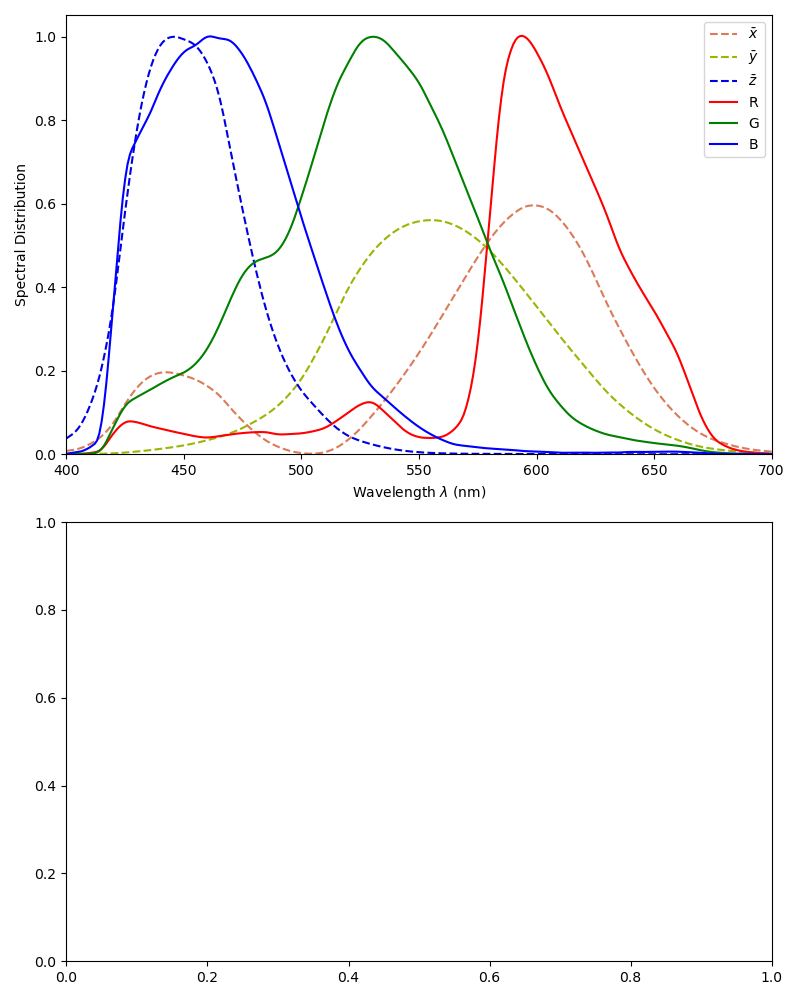

[ 1.  1.  1.]
0


c:\Users\jonis\anaconda3\envs\colour\lib\site-packages\colour\utilities\verbose.py:265: ColourRuntimeWarning: Aligning "E" illuminant shape to "CIE 1931 2 Degree Standard Observer" colour matching functions shape.
  warn(*args, **kwargs)  # noqa: B028
c:\Users\jonis\anaconda3\envs\colour\lib\site-packages\colour\utilities\verbose.py:265: ColourRuntimeWarning: Aligning "E" illuminant shape to "CIE 1931 2 Degree Standard Observer" colour matching functions shape.
  warn(*args, **kwargs)  # noqa: B028
c:\Users\jonis\anaconda3\envs\colour\lib\site-packages\colour\utilities\verbose.py:265: ColourRuntimeWarning: Aligning "E" illuminant shape to "CIE 1931 2 Degree Standard Observer" colour matching functions shape.
  warn(*args, **kwargs)  # noqa: B028


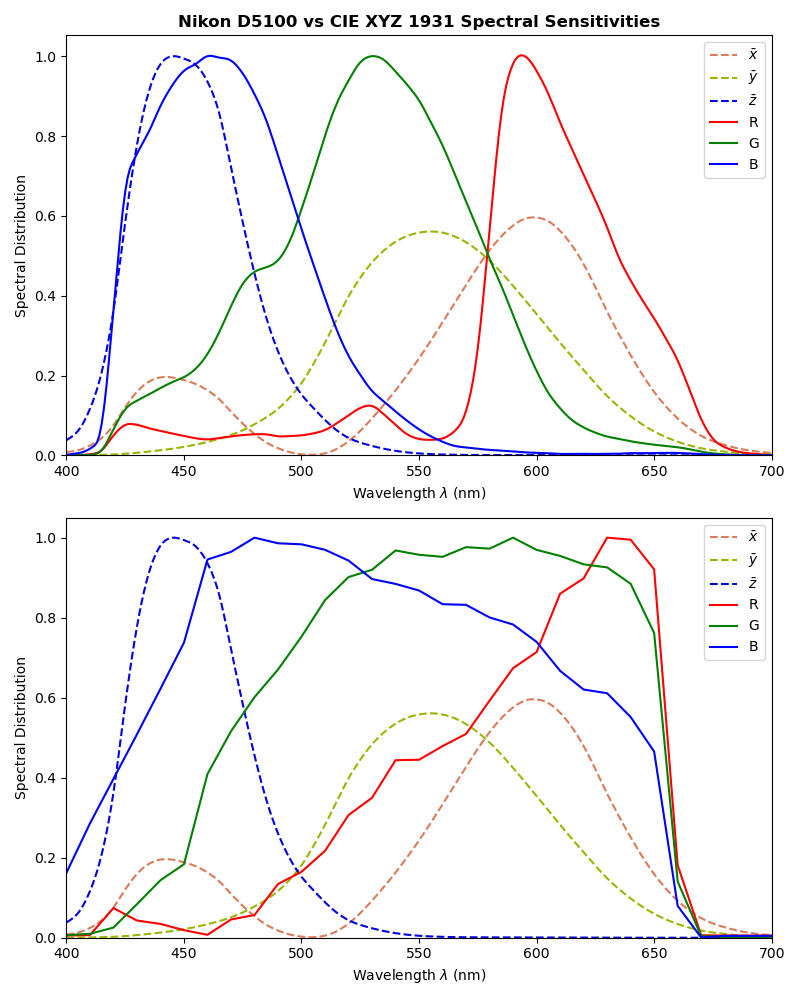

In [ ]:
# Your original plotting code here, modified to include subplots
fig, axs = plt.subplots(2, 1, figsize=(8, 10))  # Creates 2 rows and 1 column of subplots

# Plot the first set of data on the first subplot
plot_multi_sds([cmfs, MSDS_TRAIN], plot_kwargs=plot_kwargs, transparent_background=False, axes=axs[0])
axs[0].set_title("Nikon D5100 vs CIE XYZ 1931 Spectral Sensitivities", weight="bold")


MSDS_TEST, SDS_TEST = load_camera('sigma')
# Plot the second set of data on the second subplot
plot_multi_sds([cmfs, MSDS_TEST], plot_kwargs=plot_kwargs, transparent_background=False, axes=axs[1])
axs[1].set_title("Sigma SDMerill vs CIE XYZ 1931 Spectral Sensitivities", weight="bold")

# Adjust the layout so that titles and labels don't overlap
plt.tight_layout()

# Save the figure
plt.savefig("spectralsensitivities_subplot.png", transparent=False)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
pca.fit(cave_foster2004_dataset.values.T)
print(np.sum(pca.explained_variance_ratio_))
print(pca.explained_variance_ratio_)

0.986817136812
[ 0.82520032  0.12043595  0.0322493   0.00893157]
